# Security and Interpretability of Machine Learning Assignment 1

My decision was to make sound classification model: the classification of bird songs. As a dataset, I took [Bird songs from Europe (xeno-canto)](https://www.kaggle.com/monogenea/birdsongs-from-europe) dataset. However, there are a couple of difficulties with it: firstly, it is class-imbalanced, each class has different number of audio samples; secondly, I've never previously worked with audio classification, thus, had no idea on whether it is possible to make a well-performing multiclass classification model. Thus, I've stopped with binary classification of the two most represented bird species: Sylvia and Acrocephalus.

As a reference for making the classification model, I have beein using [this resource](https://medium.com/@hasithsura/audio-classification-d37a82d6715).

## Import libraries

In [25]:
import os
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import librosa

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision.models import resnet34

from tqdm.notebook import tqdm

## Read dataset

In [26]:
df = pd.read_csv('birds_large/data.csv')
df.head()

filename   label
0  Sylvia-communis-179998  Sylvia
1  Sylvia-communis-283580  Sylvia
2  Sylvia-communis-206631  Sylvia
3  Sylvia-communis-142078  Sylvia
4  Sylvia-communis-198329  Sylvia

In [27]:
df['label'].value_counts()

Acrocephalus    172
Sylvia          172
Name: label, dtype: int64

## Create the mel-spectrogram for the sound

In [28]:
def spec_to_image(spec, eps=1e-6):
    '''
    Normalize spectrogram and convert it to the b&w image with 1 channel
    '''
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled, mean, std, spec_min, spec_max

def create_spec(audio):
    '''
    Create mel-spectrogram from audio
    '''
    x, sr = librosa.load(audio, res_type='kaiser_fast', sr=None)
    if x.shape[0] < 10 * sr:
        x = np.pad(x, int(np.ceil((10 * sr - x.shape[0]) / 2)), mode='reflect')
    else:
        x = x[:10 * sr]
    spec = librosa.feature.melspectrogram(x, sr=sr, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300)
    spec_db = librosa.power_to_db(spec, top_db=80)
    return spec_db, sr

In [29]:
features = []
labels = []
for i in range(len(df)):
    # create spectrogram image
    f = 'birds_large/wav/' + df.iloc[i]['filename'] + '.mp3.wav'
    spec_db, _ = create_spec(f)
    features.append(spec_to_image(spec_db)[0][np.newaxis,...])
    # convert label to numerical label
    if df.iloc[i]['label'] == 'Sylvia':
        labels.append(1)
    else:
        labels.append(0)

In [30]:
len(features)

344

## Perform train-test split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3)

In [32]:
print(f'Train set size: {len(X_train)}')
print(f'Test set size: {len(X_test)}')

Train set size: 240
Test set size: 104


## Create pytorch dataloaders

In [33]:
X_train_t = torch.tensor(X_train)
X_test_t = torch.tensor(X_test)
y_train_t = torch.tensor(y_train)
y_test_t = torch.tensor(y_test)

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)
train_dataloader = DataLoader(train_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset)

## Create classification model

The model uses pretrained ResNet34 (as training the model from the very beginning leads to the worse results and longer training time) with the last layer changed so that it has 2 outputs for binary classification, and the first layer changed so that it accepts 1 channel input.

In [34]:
class BirdClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet34(pretrained=True)
        self.resnet.fc = nn.Linear(512, 2)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    
    def forward(self, x):
        out = self.resnet(x)
        return out

## Train the model

Training parameters have been chosen experimentally

In [35]:
model = BirdClassificationModel()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)
epochs = 10
loss_fn = nn.CrossEntropyLoss()

In [36]:
def test(model, test_loader):
    model.eval()
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for data in tqdm(test_loader):
        x, y = data
        x = x.type(torch.float32)
        y_hat = model(x)
        if y_hat.argmax(axis=1) == y:
            if y == 0:
                TN += 1
            else:
                TP += 1
        else:
            if y == 0:
                FP += 1
            else:
                FN += 1
    return TP, FP, TN, FN

In [37]:
def train(model, loss_fn, train_loader, test_loader, epochs, optimizer, lr_scheduler):
    losses = []
    accs = []
    for epoch in range(epochs):
        model.train()
        batch_losses=[]
        for data in tqdm(train_loader):
            x, y = data
            x = x.type(torch.float32)
            optimizer.zero_grad()
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        lr_scheduler.step()
        losses.append(batch_losses)
        print(f'Epoch - {epoch} Train-Loss : {np.mean(losses[-1])}')
        TP, FP, TN, FN = test(model, test_loader)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print(f'Test accuracy: {acc}')
        accs.append(acc)
    return losses, accs

In [38]:
losses, accs = train(model, loss_fn, train_dataloader, test_dataloader, epochs, optimizer, lr_scheduler)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch - 0 Train-Loss : 0.6495477795600891


  0%|          | 0/104 [00:00<?, ?it/s]

Test accuracy: 0.5576923076923077


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 0.27247062921524046


  0%|          | 0/104 [00:00<?, ?it/s]

Test accuracy: 0.6730769230769231


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch - 2 Train-Loss : 0.16044419407844543


  0%|          | 0/104 [00:00<?, ?it/s]

Test accuracy: 0.7211538461538461


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch - 3 Train-Loss : 0.10172022382418315


  0%|          | 0/104 [00:00<?, ?it/s]

Test accuracy: 0.7596153846153846


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch - 4 Train-Loss : 0.06865772406260172


  0%|          | 0/104 [00:00<?, ?it/s]

Test accuracy: 0.7596153846153846


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch - 5 Train-Loss : 0.049066977699597676


  0%|          | 0/104 [00:00<?, ?it/s]

Test accuracy: 0.7788461538461539


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch - 6 Train-Loss : 0.0368644737948974


  0%|          | 0/104 [00:00<?, ?it/s]

Test accuracy: 0.7980769230769231


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch - 7 Train-Loss : 0.028829774260520934


  0%|          | 0/104 [00:00<?, ?it/s]

Test accuracy: 0.7884615384615384


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch - 8 Train-Loss : 0.024184498563408853


  0%|          | 0/104 [00:00<?, ?it/s]

Test accuracy: 0.7884615384615384


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch - 9 Train-Loss : 0.021938783427079517


  0%|          | 0/104 [00:00<?, ?it/s]

Test accuracy: 0.7884615384615384


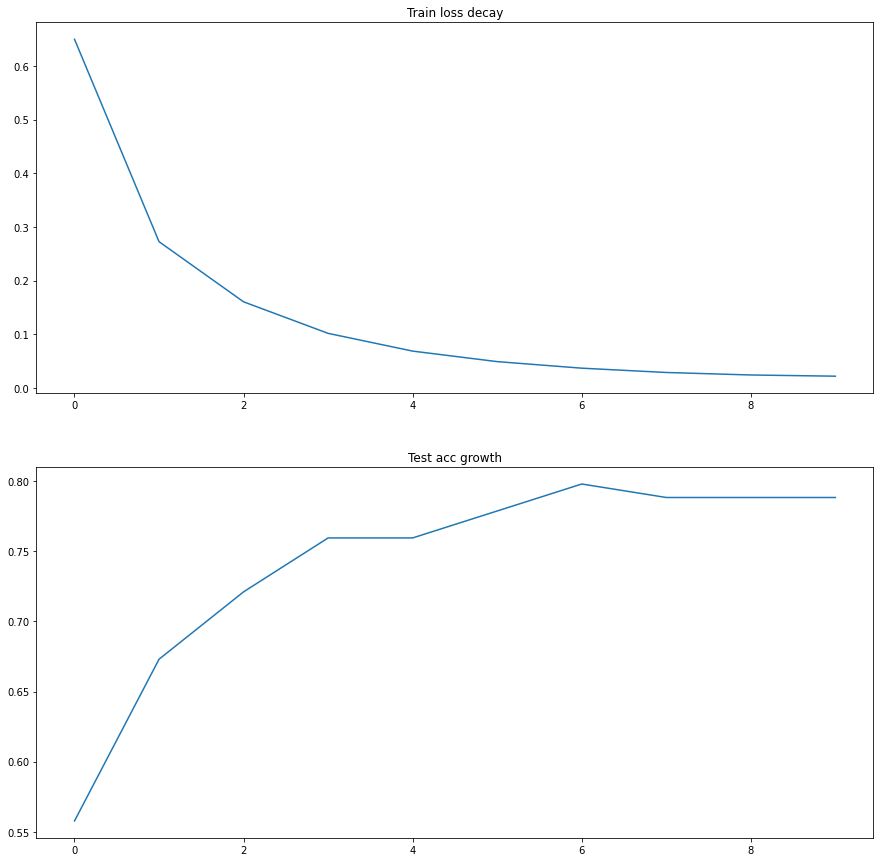

In [39]:
plt.figure(figsize=(15, 15))
plt.subplot(211)
plt.plot(list(range(len(losses))), [np.mean(x) for x in losses])
plt.title('Train loss decay')
plt.subplot(212)
plt.plot(list(range(len(losses))), accs)
plt.title('Test acc growth')
plt.show()

## Test the model

In [40]:
TP, FP, TN, FN = test(model, test_dataloader)

  0%|          | 0/104 [00:00<?, ?it/s]

In [41]:
print(f'Accuracy: {(TP + TN) / (TP + TN + FP + FN)}')
pr = TP / (TP + FP)
print(f'Precision: {pr}')
rec = TP / (TP + FN)
print(f'Recall: {rec}')
print(f'F1-score: {(2 * rec * pr / (pr + rec))}')

Accuracy: 0.7884615384615384
Precision: 0.782608695652174
Recall: 0.75
F1-score: 0.7659574468085107


In [42]:
torch.save(model.state_dict(), 'bird_classification.pt')

# Attacks on model

In [6]:
model = BirdClassificationModel()
model.load_state_dict(torch.load('bird_classification.pt'))
model.eval()

BirdClassificationModel(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

## FGSM

This algorithm attempts a single step in the direction of the ascending gradient.

In [7]:
from scipy.io import wavfile

In [8]:
import IPython

# original audio
IPython.display.Audio("birds_large/wav/Acrocephalus-arundinaceus-131536.mp3.wav")

In [9]:
spec_db, sr = create_spec("birds_large/wav/Acrocephalus-arundinaceus-131536.mp3.wav")
spec_img, mean, std, spec_min, spec_max = spec_to_image(spec_db)
spec_img = spec_img[np.newaxis,...]

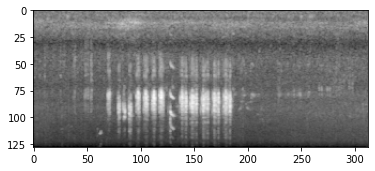

In [10]:
plt.imshow(spec_img[0], cmap='gray')
plt.show()

In [16]:
# source https://adversarial-ml-tutorial.org/adversarial_examples/
def fgsm(model, X, y, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True, dtype=torch.float32)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [17]:
X = torch.tensor(spec_img).unsqueeze(0).float()
y = torch.tensor([0])
delta = fgsm(model, X, y, 0.1)
yp = model(X + delta)
y_prev = model(X)

print(f'Prediction before an attack: {torch.softmax(y_prev, 1)}')
print(f'Prediction after an attack: {torch.softmax(yp, 1)}')

c:\users\amina\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Prediction before an attack: tensor([[0.9326, 0.0674]], grad_fn=<SoftmaxBackward>)
Prediction after an attack: tensor([[0.5959, 0.4041]], grad_fn=<SoftmaxBackward>)


In [18]:
# save the example for the future testing
fgsm_example = X + delta

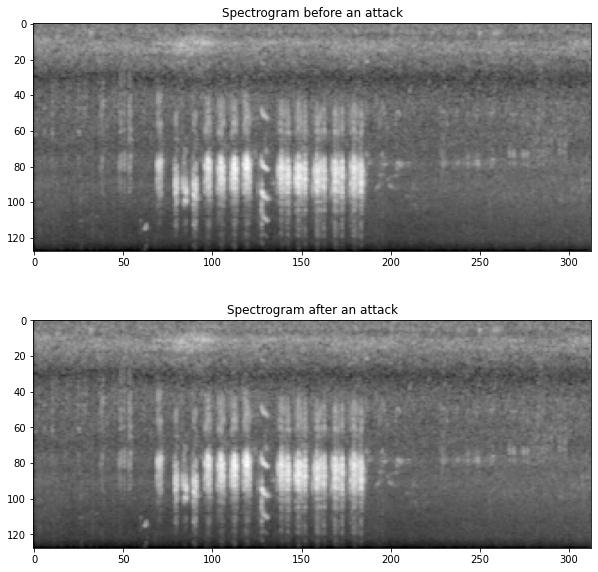

In [19]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(X.numpy()[0][0], cmap='gray')
plt.title('Spectrogram before an attack')
plt.subplot(212)
plt.imshow((X+delta).numpy()[0][0], cmap='gray')
plt.title('Spectrogram after an attack')
plt.show()

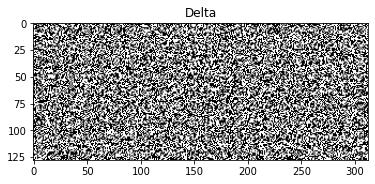

In [20]:
plt.imshow(delta.numpy()[0][0], cmap='gray')
plt.title('Delta')
plt.show()

In [21]:
def img_to_audio(img, mean, std, spec_min, spec_max, sr, eps=1e-14):
    img_norm = img * (spec_max - spec_min) / 255 + spec_min
    spec_db = img_norm * std + mean
    spec = librosa.db_to_power(spec_db)
    res = librosa.feature.inverse.mel_to_audio(spec, sr=sr, hop_length=512)
    return res

In [22]:
audio = img_to_audio((X + delta).numpy()[0][0], mean, std, spec_min, spec_max, sr)

In [23]:
wavfile.write('fgsm.wav', sr, audio)

In [24]:
IPython.display.Audio("fgsm.wav")

## PGD

It is an iterative FGSM, the continuous movement into the gradient ascent direction

In [25]:
def pgd(model, X, y, epsilon=0.1, alpha=1e3, num_iter=500):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0] * alpha * delta.grad.data).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    return delta.detach()

In [26]:
X = torch.tensor(spec_img).unsqueeze(0).float()
y = torch.tensor([0])
delta = pgd(model, X, y, 0.1, 1e3, 500)
yp = model(X + delta)
y_prev = model(X)

print(f'Prediction before an attack: {torch.softmax(y_prev, 1)}')
print(f'Prediction after an attack: {torch.softmax(yp, 1)}')

c:\users\amina\appdata\local\programs\python\python38\lib\site-packages\torch\autograd\__init__.py:147: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [1, 1, 128, 313], strides() = [0, 0, 313, 1]
param.sizes() = [1, 1, 128, 313], strides() = [40064, 40064, 313, 1] (Triggered internally at  ..\torch/csrc/autograd/functions/accumulate_grad.h:185.)
  Variable._execution_engine.run_backward(


Prediction before an attack: tensor([[0.9326, 0.0674]], grad_fn=<SoftmaxBackward>)
Prediction after an attack: tensor([[0.4469, 0.5531]], grad_fn=<SoftmaxBackward>)


In [27]:
pgd_example = X + delta

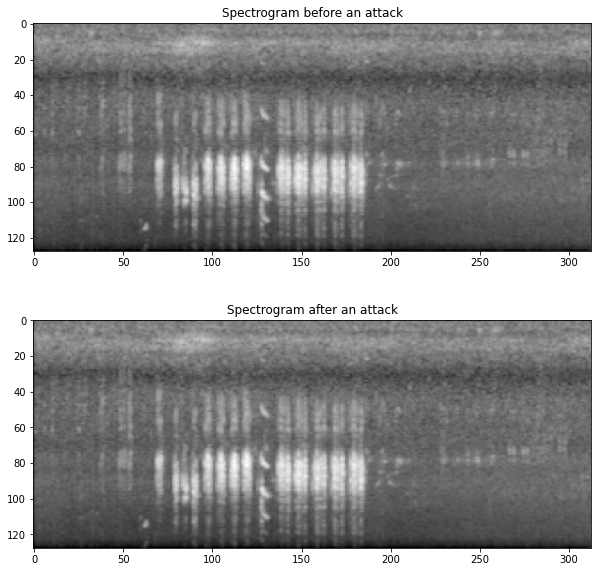

In [28]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(X.numpy()[0][0], cmap='gray')
plt.title('Spectrogram before an attack')
plt.subplot(212)
plt.imshow((X+delta).numpy()[0][0], cmap='gray')
plt.title('Spectrogram after an attack')
plt.show()

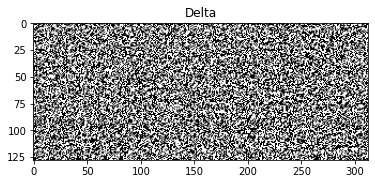

In [29]:
plt.imshow(delta.numpy()[0][0], cmap='gray')
plt.title('Delta')
plt.show()

In [30]:
audio = img_to_audio((X + delta).numpy()[0][0], mean, std, spec_min, spec_max, sr)
wavfile.write('pgd.wav', sr, audio)
IPython.display.Audio("pgd.wav")

## CW attack example

It is a distance-minimaztion attack, thus, let us choose L2-distance for the sake of convenience.

In [23]:
def cw_l2_attack(model, X, y, epsilon=0.1, c=100, kappa=0, num_iter=500, alpha=1e3):
    
    def f(x) :
        outputs = model(x)
        loss = -nn.CrossEntropyLoss()(outputs, y) + 1
        return loss
    
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = c * (1 + nn.CrossEntropyLoss()(model(X + delta), y)) + nn.MSELoss(reduction='sum')(X, X + delta)
#         print(nn.MSELoss(reduction='sum')(X, X + delta))
        loss.backward()
        delta.data = (delta + X.shape[0] * alpha * delta.grad.data).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    return delta.detach()
    
    
#     w = torch.zeros_like(X, requires_grad=True)
#     optimizer = optim.Adam([w], lr=learning_rate)
#     prev = 1e10
#     for step in range(max_iter):
#         a = 1/2 * (torch.tanh(w) + 1)
#         loss1 = nn.MSELoss(reduction='sum')(a, X)
# #         loss2 = torch.sum(c * f(a))
#         loss2 = torch.sum(c * f(a))
#         cost = loss1 - loss2
#         optimizer.zero_grad()
#         cost.backward()
#         optimizer.step()
        
#         if step % (max_iter // 10) == 0 :
#             if cost > prev :
#                 print('Attack Stopped due to CONVERGENCE....')
#                 return a
#             prev = cost
        
#         print('- Learning Progress : %2.2f %%        ' %((step + 1) / max_iter * 100), end='\r')

#     attack_images = 1/2 * (torch.tanh(w) + 1)

#     return attack_images

In [24]:
X = torch.tensor(spec_img).unsqueeze(0).float()
y = torch.tensor([0])
delta = cw_l2_attack(model, X, y).detach()
yp = model(X + delta)
y_prev = model(X)

print(f'Prediction before an attack: {torch.softmax(y_prev, 1)}')
print(f'Prediction after an attack: {torch.softmax(yp, 1)}')

Prediction before an attack: tensor([[0.9326, 0.0674]], grad_fn=<SoftmaxBackward>)
Prediction after an attack: tensor([[0.5941, 0.4059]], grad_fn=<SoftmaxBackward>)


In [33]:
cw_example = X + delta

Here we can see an interesting example of my complete inability of making a successful CW attack

At first, I was trying to implement it myself, then I became frustrated and tried the approach suggested by https://github.com/Harry24k/CW-pytorch/blob/master/CW.ipynb , but it still does not work. I did not succeed in identifying the mistake, so I would be thankful for any feedback on that!

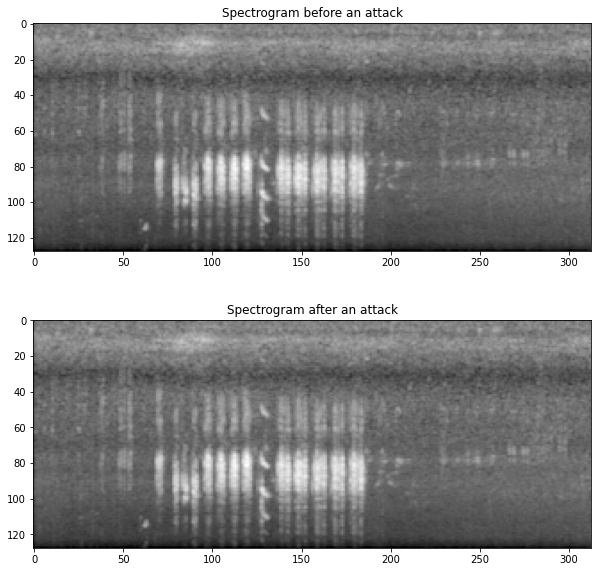

In [34]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(X.numpy()[0][0], cmap='gray')
plt.title('Spectrogram before an attack')
plt.subplot(212)
plt.imshow((X+delta).numpy()[0][0], cmap='gray')
plt.title('Spectrogram after an attack')
plt.show()

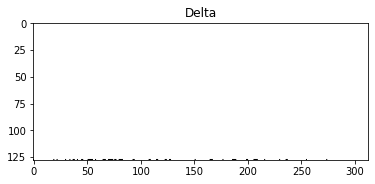

In [35]:
plt.imshow(delta.numpy()[0][0], cmap='gray')
plt.title('Delta')
plt.show()

In [36]:
audio = img_to_audio((X + delta).numpy()[0][0], mean, std, spec_min, spec_max, sr)
wavfile.write('cw.wav', sr, audio)
IPython.display.Audio("cw.wav")

# Adversarial training

In [56]:
def train_epoch(model, loss_fn, train_loader, optimizer=None, lr_scheduler=None):
    batch_losses=[]
    err = 0
    for data in tqdm(train_loader):
        x, y = data
        x = x.type(torch.float32)
        if optimizer:
            optimizer.zero_grad()
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        batch_losses.append(loss.item())
        if optimizer:
            loss.backward()
            optimizer.step()
        err += (y_hat.max(dim=1)[1] != y).sum().item()
    if lr_scheduler:
        lr_scheduler.step()
    return err / len(train_loader.dataset), np.mean(batch_losses)

def train_epoch_adversarial(model, loss_fn, train_loader, attack, optimizer=None, lr_scheduler=None):
    batch_losses = []
    err = 0
    for data in tqdm(train_loader):
        x, y = data
        x = x.type(torch.float32)
        if optimizer:
            optimizer.zero_grad()
        delta = attack(model, x, y)
        yp = model(x + delta)
        loss = loss_fn(yp, y)
        batch_losses.append(loss.item())
        if optimizer:
            loss.backward()
            optimizer.step()
        err += (yp.max(dim=1)[1] != y).sum().item()
    if lr_scheduler:
        lr_scheduler.step()
    return err / len(train_loader.dataset), np.mean(batch_losses)

## Evaluation of the non-robust model

In [57]:
model_not_robust = BirdClassificationModel()
optimizer = optim.Adam(model_not_robust.parameters(), lr=1e-5)
epochs = 5
loss_fn = nn.CrossEntropyLoss()

In [58]:
for epoch in range(epochs):
    model_not_robust.train()
    train_err, train_loss = train_epoch(model_not_robust, loss_fn, train_dataloader, optimizer)
    model_not_robust.eval()
    test_err, test_loss = train_epoch(model_not_robust, loss_fn, test_dataloader)
    adv_err, adv_loss = train_epoch_adversarial(model_not_robust, loss_fn, test_dataloader, fgsm)
    print(f'Epoch {epoch}')
    print(f'\tTrain err {train_err}\tTrain loss {train_loss}')
    print(f'\tTest err {test_err}\tTest loss {test_loss}')
    print(f'\tAdversarial err {adv_err}\tAdversarial loss {adv_loss}')
    print('')

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 0
	Train err 0.42083333333333334	Train loss 0.749421219031016
	Test err 0.4519230769230769	Test loss 0.7400403038885158
	Adversarial err 0.6826923076923077	Adversarial loss 1.1952669616215503



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 1
	Train err 0.1125	Train loss 0.32833690543969474
	Test err 0.3173076923076923	Test loss 0.5998624332804376
	Adversarial err 0.7692307692307693	Adversarial loss 1.271190379674618



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 2
	Train err 0.029166666666666667	Train loss 0.19445574134588242
	Test err 0.25961538461538464	Test loss 0.5313464803621173
	Adversarial err 0.7596153846153846	Adversarial loss 1.2541119873237152



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 3
	Train err 0.0	Train loss 0.1257194255789121
	Test err 0.22115384615384615	Test loss 0.48395750677445903
	Adversarial err 0.7019230769230769	Adversarial loss 1.238484138264679



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 4
	Train err 0.0	Train loss 0.08643592024842899
	Test err 0.20192307692307693	Test loss 0.45207808423303786
	Adversarial err 0.6923076923076923	Adversarial loss 1.2395171711507897



In [59]:
torch.save(model_not_robust.state_dict(), "model_not_robust.pt")

## An attempt to train a robust model

In [63]:
model_robust = BirdClassificationModel()
optimizer = optim.Adam(model_robust.parameters(), lr=1e-5)
epochs = 5
loss_fn = nn.CrossEntropyLoss()

In [64]:
for epoch in range(epochs):
    model_robust.train()
    adv_err, adv_loss = train_epoch_adversarial(model_robust, loss_fn, train_dataloader, fgsm, optimizer)
    model_robust.eval()
    test_err, test_loss = train_epoch(model_robust, loss_fn, test_dataloader)
    
    print(f'Epoch {epoch}')
    print(f'\tAdversarial err {adv_err}\tAdversarial loss {adv_loss}')
    print(f'\tTest err {test_err}\tTest loss {test_loss}')
    print('')

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 0
	Adversarial err 0.5541666666666667	Adversarial loss 1.6553576191266377
	Test err 0.4230769230769231	Test loss 0.848045086595588



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 1
	Adversarial err 0.45	Adversarial loss 1.0356646100680034
	Test err 0.36538461538461536	Test loss 0.7159015124914452



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 2
	Adversarial err 0.37916666666666665	Adversarial loss 0.7246148347854614
	Test err 0.3269230769230769	Test loss 0.6181848101371613



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 3
	Adversarial err 0.2916666666666667	Adversarial loss 0.49764321446418763
	Test err 0.3076923076923077	Test loss 0.5270392495082118



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 4
	Adversarial err 0.14583333333333334	Adversarial loss 0.33976684312025707
	Test err 0.2403846153846154	Test loss 0.45708321425795123



In [65]:
torch.save(model_robust.state_dict(), "model_robust.pt")